# Reservoir Computing to Predict the Lorenz System

We'll use reservoir computing to predict the evolution of the Lorenz model.

## The Lorenz System

The Lorenz model, developed by meteorologist Edward Lorenz, is a simplified representation of atmospheric convection. It's expressed through a system of three differential equations, nonlinear and deterministic, showcasing chaotic behavior. The equations relate to a two-dimensional fluid layer uniformly warmed from below and cooled from above. In this model:

- $x$ is proportional to the rate of convection,
- $y$ represents the horizontal temperature variation,
- $z$ corresponds to the vertical temperature variation.

These quantities are described in terms of their rate of change with respect to time. The Lorenz model is famous for its 'Lorenz attractor,' a butterfly-shaped pattern formed by its set of chaotic solutions. This attractor illustrates the concept of the 'butterfly effect,' where small changes in initial conditions can lead to vastly different outcomes.

### Constants in the Lorenz System

The constants in the Lorenz equations are:

- $\sigma$: Proportional to the Prandtl number, representing the fluid's viscosity and thermal conductivity.
- $\rho$: Related to the Rayleigh number, signifying the temperature difference between the bottom and top of the layer.
- $\beta$: Associated with certain physical dimensions of the fluid layer.

These parameters are crucial in determining the system's behavior, highlighting the interplay between fluid dynamics, temperature variations, and chaotic systems. The Lorenz model's simplicity, coupled with its ability to exhibit complex and unpredictable behavior, makes it a cornerstone in the study of dynamical systems and chaos theory.


We implement a function to calculate the next step in the Lorenz system.

```python
def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt
    
    return t + dt, x + dx, y + dy, z + dz
```

We now propagate it to obtain some trajectories, starting from the initial conditions used by Lorenz.

```python
import numpy as np

def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""

    # Preallocate arrays for the trajectory
    t = np.zeros(iter_num + 1)
    x = np.zeros(iter_num + 1)
    y = np.zeros(iter_num + 1)
    z = np.zeros(iter_num + 1)

    # Set initial values
    t[0], x[0], y[0], z[0] = t0, x0, y0, z0

    # Integration loop for the Lorenz system
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = (
            lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)
        )
    
    return t, x, y, z
```

In [7]:
from for_lorenz import lorenz

t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, 
                    sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

We finally plot the trajectory in phase space illustrating the Lorenz attractor.

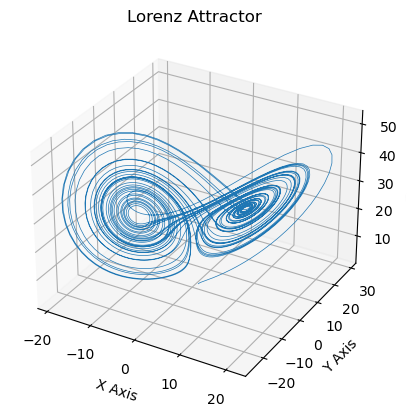

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot(x, y, z, lw=0.5)

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

We can also plot the trajectories in time.

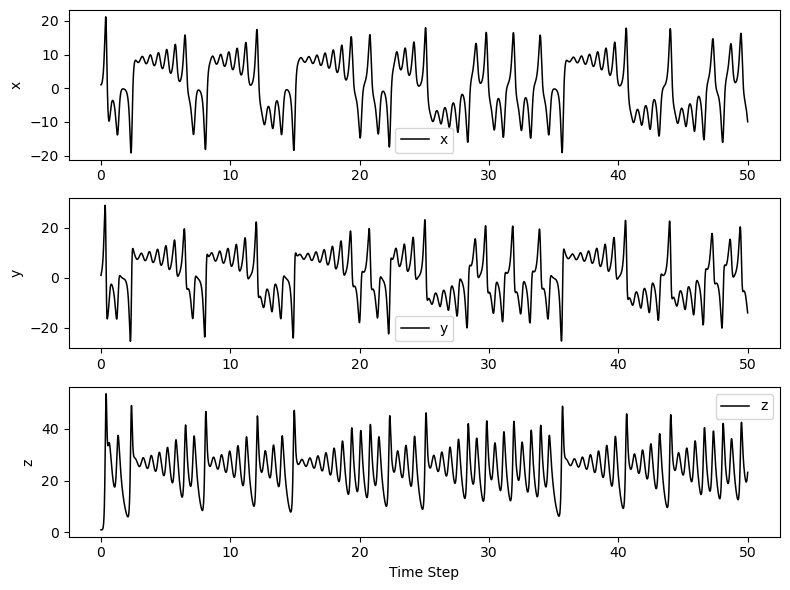

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, label="x", color="k", lw=1.1)  # lw is line width
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t, y, label="y", color="k", lw=1.1)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t, z, label="z", color="k", lw=1.1)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()


## Demonstrate the Butterfly Effect

We now demonstrate the chaotic nature of the Lorenz system, popularly known as the 'butterfly effect'.
We change the numpy array from the default float64 to float32 and repeat the previous calculations.

In [19]:
t32, x32, y32, z32 = lorenz(t0=0, x0=1 + 0.000_001, y0=1, z0=1, dt=0.01, 
                    sigma=10, rho=28, beta=8 / 3, 
                    iter_num=5_000)

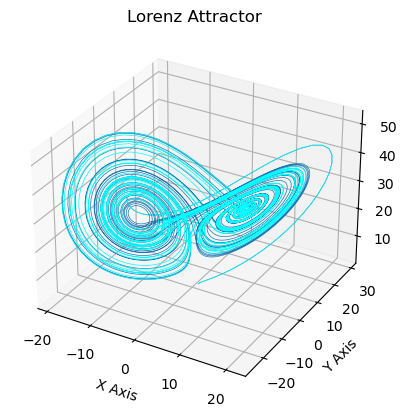

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot(x, y, z, lw=0.5, label="float64")
ax.plot(x32, y32, z32, lw=0.5, color="cyan", label="float32")

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

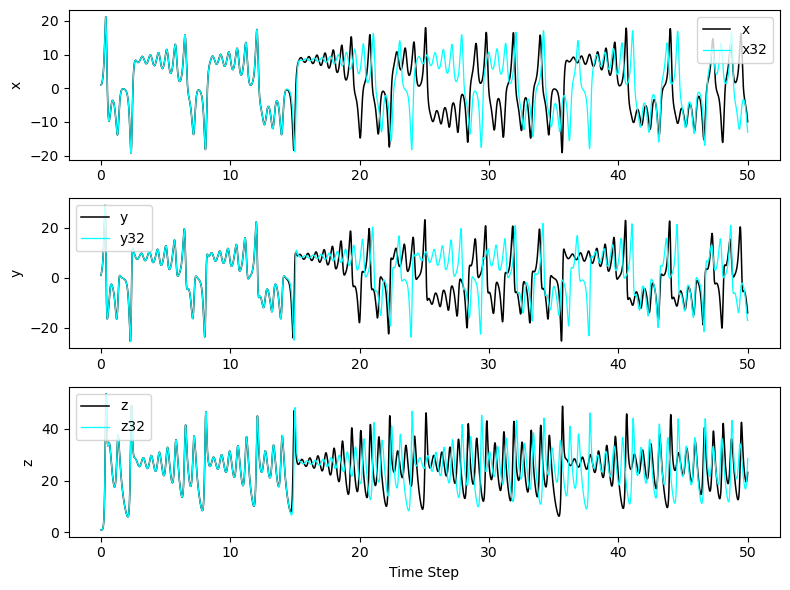

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, label="x", color="k", lw=1.1)
axs[0].plot(t32, x32, label="x32", color="cyan", lw=0.9)
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t, y, label="y", color="k", lw=1.1)
axs[1].plot(t32, y32, label="y32", color="cyan", lw=0.9)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t, z, label="z", color="k", lw=1.1)
axs[2].plot(t32, z32, label="z32", color="cyan", lw=0.9)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()


## Implement Reservoir Computer

We now implement a reservoir computer.

We start by implementing the sigmoid function with a twist to carefully handle large positive and negative values of `x` to prevent issues with floating-point arithmetic overflow, common in the standard sigmoid function for extreme values of `x`.

In [ ]:
def sigmoid(x):
    """Compute the sigmoid function for the input array."""
    
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))


In [ ]:
dim_system = 3
dim_reservoir = 300

scaling_factor = 1.1
edge_probability = 0.1

We now set up the reservoir computer.

In [ ]:
import networkx as nx

W_in = 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - .5)

reservoir_state = np.zeros(dim_reservoir)

graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
graph = nx.to_numpy_array(graph)
A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
eigenvalues, _ = np.linalg.eig(A)
A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor

W_out = np.zeros((dim_system, dim_reservoir))

## Obtain Reservoir Computer Predictions

Finally, we can use the reservoir computer to get some predictions.

We start by generaing a long Lorenz trajectory and splitting it into training and validation sets.

In [ ]:
iter_num = 10_000

t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, 
                    sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)

# Combine the lists into a single list of 3-tuples
xyz = list(zip(x, y, z))

# Split the data into training and validation sets
split_ratio = 0.50
split_idx = int(iter_num * split_ratio)

t_train = t[:split_idx]
xyz_train = np.array(xyz[:split_idx])

t_val = t[split_idx:]
xyz_val = np.array(xyz[split_idx:])

We now train the reservoir computer.

In [ ]:
regularization_factor = 0.0001

R = np.zeros((dim_reservoir, xyz_train.shape[0]))
for i in range(xyz_train.shape[0]):
    R[:, i] = reservoir_state
    reservoir_state = sigmoid(np.dot(A, reservoir_state) 
                              + np.dot(W_in, xyz_train[i]))
    
Rt = np.transpose(R)
inverse_part = np.linalg.inv(np.dot(R, Rt) 
                             + regularization_factor * np.identity(R.shape[0]))
W_out = np.dot(np.dot(xyz_train.T, Rt), inverse_part)

We now use the reservoir computer to predict the Lorenz system.

In [ ]:
step_to_be_predicted = len(xyz_val)

xyz_pred = np.zeros((step_to_be_predicted, dim_system))
for i in range(step_to_be_predicted):
    xyz_pred[i] = np.dot(W_out, reservoir_state)
    reservoir_state = sigmoid(np.dot(A, reservoir_state) 
                              + np.dot(W_in, xyz_pred[i]))

## Compare Reservoir Computer Predictions with Lorenz Model

In [ ]:
x_val, y_val, z_val = xyz_val[:, 0], xyz_val[:, 1], xyz_val[:, 2]
x_pred, y_pred, z_pred = xyz_pred[:, 0], xyz_pred[:, 1], xyz_pred[:, 2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot(x_val, y_val, z_val, lw=0.5, label="Lorenz system")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, color="orange", label="prediction")

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t_val, x_val, label="x Lorenz", color="k", lw=1.1)
axs[0].plot(t_val, x_pred, label="x prediction", color="orange", lw=0.9)
axs[0].set_ylabel("x")
axs[0].legend()

axs[1].plot(t_val, y_val, label="y Lorenz", color="k", lw=1.1)
axs[1].plot(t_val, y_pred, label="y prediction", color="orange", lw=0.9)
axs[1].set_ylabel("y")
axs[1].legend()

axs[2].plot(t_val, z_val, label="z Lorenz", color="k", lw=1.1)
axs[2].plot(t_val, z_pred, label="z prediction", color="orange", lw=0.9)
axs[2].set_ylabel("z")
axs[2].legend()

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()